In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,107.785096,11.976122,15.430313,9
Email Auth and Security,227.432418,56.858105,79.862686,4
"Jane Eyre, Bronte",417.180782,52.147598,77.670122,8
Azure VM + Developer,596.355582,17.539870,31.817139,34
TSQL,846.118802,35.254950,49.949241,24
Azure AD Authentication,880.814331,73.401194,157.692456,12
RAG Project,916.659199,101.851022,255.754626,9
Logging in Python,1059.241083,75.660077,121.255772,14
Azure Private DNS,1638.483038,86.235949,163.117423,19
Azure Functions + PP365,2189.320672,104.253365,224.702740,21


# Histogram

sum of ages: ~51297.20


<Axes: >

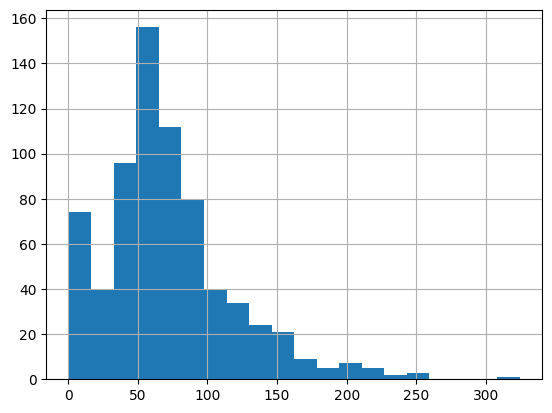

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51297.20


<Axes: >

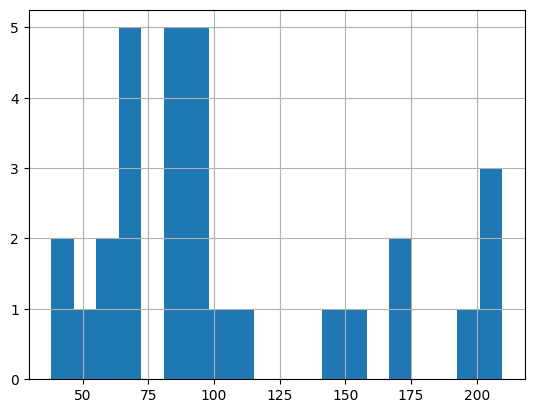

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 709
Total card age: 51297.20


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
168,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,324.274402,100.064045,-324.274402,2401.537078,0.611435,0,0,-324.274402
169,Terraform,Splat Operator:\nDefinition: The splat operato...,bcc5e4ead8de0d713173b59d20a15254,133.116771,100.064045,-324.274402,2401.537078,0.611435,3,0,-133.116771
170,Terraform,Debugging with TF_LOG:\n\nDefinition: Setting ...,71591e1c802859eecdb55827e8bcb850,121.812453,100.064045,-324.274402,2401.537078,0.611435,6,0,-121.812453
171,Terraform,Terraform Console:\nDefinition: An interactive...,8f686528321605239405a40660149838,98.421714,100.064045,-324.274402,2401.537078,0.611435,9,0,-98.421714
413,Terraform,Configuration Blocks:\nThese are the building ...,d7218f9be151db8a29ee209a8d1b80d4,81.329548,100.064045,-324.274402,2401.537078,0.611435,12,0,-81.329548
646,Terraform,Remote Backends and Interpolation:\nDefinition...,b7013ea87c70a697aac757fb6595726b,72.872394,100.064045,-324.274402,2401.537078,0.611435,15,0,-72.872394
174,Terraform,Dynamic Blocks:\nDefinition: Allow you to cons...,28763e7ddcf4cb0a2802e902b77a7035,67.041518,100.064045,-324.274402,2401.537078,0.611435,18,0,-67.041518
175,Terraform,For Expressions:\n\nDefinition: These are used...,e4b58ae41b4f16b9449769c145f4fde7,54.242432,100.064045,-324.274402,2401.537078,0.611435,21,0,-54.242432
206,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,255.754626,101.851022,-255.754626,916.659199,0.335704,0,0,-255.754626
207,RAG Project,Fixture\nA reusable setup block in pytest that...,4f93846aa03e6a3631c874b835eb0809,114.187592,101.851022,-255.754626,916.659199,0.335704,3,0,-114.187592


## Card Count

In [36]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
17,Azure Developer Associate,App Configuration doesn't version key values a...,c5b1da2f26c3dc2ad56cbaba6c51b9ed,0.331822,57.967692,-193.710275,3593.996913,0.137417,61,1,-0.331822
16,Azure Developer Associate,For the .NET SDK for Azure Cosmos DB for NoSQL...,e2ff6f3c584a2c6c5faf78dcae2eb263,2.041637,57.967692,-193.710275,3593.996913,0.137417,60,0,-2.041637
262,Azure Developer Associate,Configuration data stored in an App Configurat...,22293608d8680b7f657f335dbf029202,2.803347,57.967692,-193.710275,3593.996913,0.137417,59,2,-2.803347
193,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,2.862622,70.720309,-120.671071,2192.329570,0.519777,30,0,-2.862622
261,Azure Developer Associate,Feature management is a modern software-develo...,0bbf18293899f4165444a093909158a0,2.955288,57.967692,-193.710275,3593.996913,0.137417,58,1,-2.955288
498,Azure Developer Associate,"In Azure App Configuration,\nFeature flag: A f...",8bcb1de29c054bd4964e31961734bbbd,2.978351,57.967692,-193.710275,3593.996913,0.137417,57,0,-2.978351
499,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,3.557410,57.967692,-193.710275,3593.996913,0.137417,56,2,-3.557410
15,Azure Developer Associate,Azure App Configuration encrypts sensitive inf...,fc0360a578522e808e4d680619664a40,3.593722,57.967692,-193.710275,3593.996913,0.137417,55,1,-3.593722
496,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,6b266a08728213cd70fbb1cf8e56b84d,4.343099,57.967692,-193.710275,3593.996913,0.137417,54,0,-4.343099
575,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,4.652202,48.672611,-169.001116,3650.445849,0.664334,74,2,-4.652202


In [39]:
existing_cards.head(10).sum()

head                   TerraformTerraformTerraformTerraformTerraformT...
body                   Terraform allows you to manage the resources i...
hash                   05fa95392fe5544d07eec6db3a93ccb6bcc5e4ead8de0d...
age                                                           1323.05345
subject_mean_age                                             1004.214404
subject_highest_age                                          -3105.70447
subject_age_sum                                             21045.615024
head_random_roll                                                5.562888
count                                                                 87
n_fold                                                                 0
neg_age                                                      -1323.05345
dtype: object

In [40]:
existing_cards['age'].mean()

72.351477883547